In [18]:
import dill
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from collections import defaultdict

In [19]:
import numpy as np
from scipy.optimize import minimize_scalar

In [20]:
import sys
sys.path.append('/shares/bulk/earapidis/dev/Fast-Crossbar-Sim/python')
import crossbar
import importlib


In [21]:
importlib.reload(crossbar)

<module 'crossbar' from '/shares/bulk/earapidis/dev/Fast-Crossbar-Sim/python/crossbar.py'>

In [22]:
from crossbar import _collect_currents_

In [23]:
model_idx = 1
models_dir = os.path.abspath(f"/shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_{model_idx}")

x_kde_path = os.path.join(models_dir,"x_kde.pkl")
w_kde_path = os.path.join(models_dir,"w_kde.pkl")

with open(x_kde_path,"rb") as f:
    x_kde = dill.load(f)

with open(w_kde_path,"rb") as f:
    w_kde = dill.load(f)


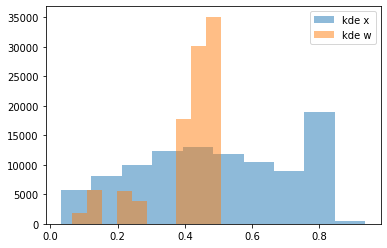

In [24]:
num_samples = 100000
x = x_kde.resample(num_samples)
w = w_kde.resample(num_samples)
x = x.squeeze()
w = w.squeeze()
bins = 10
plt.hist(x,label="kde x",alpha=0.5,bins=bins)
plt.hist(w,label="kde w",alpha=0.5,bins=bins)
plt.legend()

In [25]:
def find_optimal_divisors(S, T):
    """
    Finds the optimal divisor d to minimize the error between target labels T 
    and rounded predicted labels S/d.
    
    Parameters:
        S (array-like): Sum values corresponding to each peak.
        T (array-like): True integer target labels.
    
    Returns:
        float: The optimal divisor d.
    """
    S = np.array(S, dtype=float)
    T = np.array(T, dtype=float)
    
    def cost_function(d):
        if d <= 0:  # Ensure d is positive to avoid division errors
            return np.inf
        predicted_labels = np.floor((S+0.5*d) / d)
        # predicted_labels = np.round(S / d)
        return np.sum(np.power(T - predicted_labels,2))  # Minimize absolute error

    # Use Brent’s method to find optimal d
    # result = minimize_scalar(cost_function, method='brent')
    result = minimize_scalar(cost_function, bounds=(0, 61), method='bounded')
    
    return result.x  # Return the best divisor found

In [26]:
def generate_samples(x_kde,w_kde,mapping,num_samples):
    if mapping:
        x_per = 0.5
        w_per = 0.5
        x = [x_per for i in range(num_samples)]
        w = [w_per for i in range(num_samples)]
    else:
        x = x_kde.resample(num_samples)
        w = w_kde.resample(num_samples)
        x = x.squeeze()
        w = w.squeeze()
    return (x,w)
        
    

In [27]:
def run_samples(x,w,Num_rows,Num_columns,max_workers):
    num_runs = 1
    transient = False
    tasks = []
    for idx, _x_ in enumerate(x):
        _w_ = w[idx]
        tasks.append((idx,_x_,_w_,Num_rows,Num_columns,num_runs,transient))
    outputs = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(_collect_currents_, *t) for t in tasks]
        for f in tqdm(as_completed(futures),total=len(tasks),desc="running samples"):
            output = f.result()
            outputs.append(output)
    return outputs

In [28]:
def generate_adc_steps(outputs,mode, Num_columns):
    macs = []
    mvms = []
    for idx, output in outputs:
        mac = output[0]
        mvm = output[1]
        macs.append(mac)
        mvms.append(mvm)
    
    if mode=="gs":
        mac = np.ravel(np.stack(macs))
        mvm = np.ravel(np.stack(mvms))
        gs_step = find_optimal_divisors(mac,mvm)
        steps = [gs_step for i in range(Num_columns)]
    elif mode=="cs":
        mac = np.stack(macs)
        mvm = np.stack(mvms)
        # print(mac.shape)
        # print(mvm.shape)
        steps = []

        for column in tqdm(range(Num_columns),disable=True):
            _mac_ = np.ravel(mac[:,column])
            _mvm_ = np.ravel(mvm[:,column])
            # print(_mac_.shape)
            # print(_mvm_.shape)
            step = find_optimal_divisors(_mac_,_mvm_)
            steps.append(step)
    else:
        raise Exception(f"invalid mode: {mode}, select gs or cs")
    steps = np.array(steps)
    return steps

In [29]:
# mappings = [False]
mappings = [True,False]
modes = ["gs","cs"]
Num_rows = 32
Num_columns = 32
num_samples = 10000
max_workers = 20
adc_steps = defaultdict()

for mapping in mappings:
    print(f"mapping: {mapping}")
    x, w = generate_samples(x_kde,w_kde,mapping,num_samples)
    outputs = run_samples(x,w,Num_rows,Num_columns,max_workers)
    for mode in modes:
        print(f"mode: {mode}")
        steps = generate_adc_steps(outputs,mode,Num_columns)
        adc_steps[f"mapping_{mapping}-{mode}"] = steps
    

mapping: True


running samples: 100%|██████████| 10000/10000 [00:30<00:00, 323.27it/s]


mode: gs
mode: cs
mapping: False


running samples: 100%|██████████| 10000/10000 [00:31<00:00, 319.79it/s]


mode: gs
mode: cs


In [30]:
ideal_current = 61.057
adc_steps["ideal"] = np.array([ideal_current for i in range(Num_columns)])

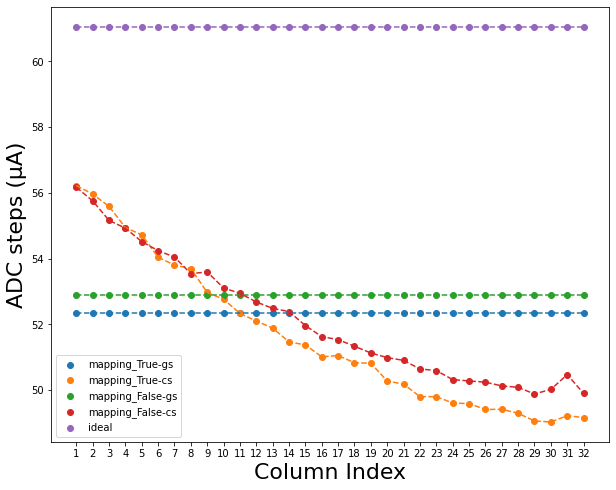

In [31]:
fig, ax = plt.subplots()
x_ticks = np.arange(Num_columns)
fig.set_size_inches((10,8))
for mode , steps in adc_steps.items():
    plt.scatter(x_ticks,steps,label=f"{mode}")
    plt.plot(x_ticks,steps,linestyle="--")
plt.xlabel("Column Index",fontsize=22)
plt.ylabel("ADC steps (μΑ)",fontsize=22)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks+1)
plt.legend()

In [32]:
adc_steps["ideal-no-comp"] = np.array([ideal_current for i in range(Num_columns)])


In [33]:
adc_steps_path = os.path.join(models_dir,"adc_steps.pkl")
with open(adc_steps_path,"wb") as f:
    dill.dump(adc_steps,f)